# Анализ оттока клиентов банка

**Описание и план проекта**  
Проект связан с анализом оттока клиентов: банковские маркетологи выяснили, что удерживать старых клиентов дешевле, чем привлекать новых, а наша задача - помочь им в этом, чтобы «Метанпромбанк» рос, крепчал и развивался.
  
Мы проанализируем клиентов банка и выделим сегменты клиентов, которые склонны уходить из банка.  
Проведём исследовательский анализ данных, определим все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравним портреты типичных клиентов, которые склонны и не склонны уходить из банка и т.д)  
  
Сформулируем и проверим статистические гипотезы:    
- гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались    
- гипотезу относительно представленных данных, которая поможет внести ясность в исследование  
  
Объединяя признаки отточности, сформируем сегменты, отберём из них лучшие и дадим по ним рекомендации.  
  
  
**Декомпозиция проекта:**  
1. Загрузка и описание данных.
2. Подготовка данных:
- анализ природы пропусков и их разумная обработка;
- кодирование (для использования в анализе корреляции).
3. EDA:
- анализ распределения признаков, в том числе в разрезе оттока (непрерывные - ищем отточные интервалы, категориальные дискретные - ищем значения признака с оттоком выше, чем по банку);
- корреляционный анализ (в том числе интерпретация).
4. Проверка двух статистических гипотез с обоснованием инструмента.
5. Подведение промежуточных итогов - выводы по результатам EDA, корреляционного анализа и гипотез, выделение признаков, влияющих на отток.
6. Сегментация (неузкие сегменты (от 500 клиентов на сегмент); отток больше, чем средний уровень оттока по банку).
7. Приоритизация сегментов (у маркетинга нет автоматизированных систем, работаю руками).
8. Формирование рекомендаций (таргетированных) по работе с ними
  

## Загрузка и описание данных

In [1]:
# загружаем необходимые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
banks = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
banks

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [3]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
banks.describe().round(2)

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00,10000.00,9974.00,10000.00,7.705000e+03,10000.00,10000.00,10000.00,10000.00,10000.00
mean,171814.71,848.70,42.73,2.63,8.277943e+05,1.87,0.68,0.52,147866.89,0.18
std,33708.24,65.45,12.18,1.98,1.980614e+06,0.79,0.47,0.50,139388.51,0.39
min,94561.00,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00
25%,142810.25,802.00,33.00,0.00,2.955542e+05,1.00,0.00,0.00,75251.90,0.00
50%,172728.00,853.00,40.00,3.00,5.242722e+05,2.00,1.00,1.00,119658.10,0.00
75%,201261.75,900.00,51.00,4.00,9.807058e+05,2.00,1.00,1.00,174500.54,0.00
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00


Описание датасета /datasets/bank_scrooge.csv:  
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.  
  
Всего 10 тысяч строк и 12 колонок:  
user_id — идентификатор пользователя  
score — баллы кредитного скоринга  
city — город  
gender — пол  
age — возраст  
equity — количество баллов собственности  
balance — баланс на счёте  
products — количество продуктов, которыми пользуется клиент  
credit_card — есть ли кредитная карта  
last_activity — активный клиент  
est_salary — оценочный доход клиента  
сhurn — признак оттока.  
  
**Вывод по разделу**  
Загрузили все необходимые библиотеки; загрузили, посмотрели, оценили и описали датасет, содержание его опишем в следующем разделе.

## Подготовка данных  
### Проверка корректности наименований колонок и переименование  
  
Переименуем два столбца, названия которых не соответствуют стандартам Python

In [5]:
banks.rename(columns={'USERID':'user_id', 'EST_SALARY':'est_salary'}, inplace=True)
banks.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Исследование соответствия и приведение типов

Ранее выводили info() о таблице с указанием типов данных по столбцам - в целом типы соответствуют данным, приведение не требуется. 

### Анализ природы пропусков и их разумная обработка

In [6]:
banks.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

Из 10000 строк 26 пропусков с столбце с возрастом и 2295 в столбце баланса на счёте. Пропусков в столбце возраста очень мало, поэтому удалим их

In [7]:
banks=banks.dropna(subset=['age'])

Проверим ещё раз пропуски после удаления:

In [8]:
banks['age'].isnull().sum()

0

А вот пустых данных о балансе много, почти 23%. Возможно это связано как раз с тем, что клиент ушёл из банка, проверим это:

In [9]:
banks[banks['balance'].isna()]['churn'].value_counts()

0    2266
1      13
Name: churn, dtype: int64

Гипотеза не подтвердилась, лишь 13 клиентов с незаполненным балансом ушли.  
Проверим, как эти пропуски зависят от имеющихся данных - тогда можно будет выбрать более удачную стратегию работы с ними. Сравним остальные количественные параметры у строк с пропущенным балансом с остальными строками.

In [10]:
display(banks[banks['balance'].isna()].describe().round(2))
display(banks[banks['balance'].notnull()].describe().round(2))

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2279.00,2279.00,2279.00,2279.00,0.0,2279.00,2279.00,2279.00,2279.00,2279.00
mean,171904.89,865.36,42.09,0.05,NaN,1.16,0.82,0.55,226345.42,0.01
std,33303.22,89.55,11.94,0.23,NaN,0.40,0.39,0.50,199825.59,0.08
min,114182.00,642.00,18.00,0.00,NaN,0.00,0.00,0.00,20274.03,0.00
25%,142992.50,871.00,33.00,0.00,NaN,1.00,1.00,0.00,120217.38,0.00
50%,172304.00,903.00,40.00,0.00,NaN,1.00,1.00,1.00,174347.87,0.00
75%,201257.00,922.00,49.00,0.00,NaN,1.00,1.00,1.00,240372.78,0.00
max,229145.00,990.00,86.00,3.00,NaN,3.00,1.00,1.00,1333687.36,1.00


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,7695.00,7695.00,7695.00,7695.00,7.695000e+03,7695.00,7695.00,7695.00,7695.00,7695.00
mean,171710.89,843.74,42.92,3.39,8.272456e+05,2.08,0.64,0.52,124520.39,0.23
std,33812.86,55.34,12.24,1.58,1.980327e+06,0.76,0.48,0.50,104667.11,0.42
min,94561.00,689.00,18.00,0.00,0.000000e+00,1.00,0.00,0.00,2546.30,0.00
25%,142638.00,801.00,33.00,2.00,2.956987e+05,2.00,0.00,0.00,67556.98,0.00
50%,172710.00,840.00,40.00,4.00,5.242953e+05,2.00,1.00,1.00,106250.18,0.00
75%,201145.50,882.00,52.00,5.00,9.800512e+05,2.00,1.00,1.00,155144.60,0.00
max,229136.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00


У клиентов с незаполненным балансом ниже количество баллов собственности, меньшее количество продуктов, выше зарплата и почти у всех стоит 0 в столбце оттока, то есть они ещё пользуются услугами банка.  
  
Сложно определить природу этих пропусков и нет точного понимания чем заполнить их, а заполнение данных о балансе каким-то средним или медианным значением исказит анализ, поэтому оставим эти пропуски.  

### Кодирование переменных города и пола клиентов  
  
Для использования метода корреляции добавим столбцы, в которых будут логические значения, обозначающие каждый из трёх городов, и так же с полом.

In [11]:
banks['city_dum']=banks['city']
banks['gen_dum']=banks['gender']
banks=pd.get_dummies(banks, columns=['city_dum','gen_dum'], prefix='', prefix_sep='')
banks.head(10)

/tmp/ipykernel_85/1006998002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banks['city_dum']=banks['city']
/tmp/ipykernel_85/1006998002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banks['gen_dum']=banks['gender']


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,Ж,М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0,1,0,0,1
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0,1,1,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,0,0,1,1,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,0,0,1,0,1
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,0,0,1,1,0


### Поиск и удаление дубликатов

In [12]:
banks.duplicated().sum()

0

Дубликатов в данных нет  
  
Проверим на уникальность/наличие дубликатов столбец с id клиентов:

In [13]:
banks['user_id'].duplicated().sum()

50

Всего 50 дубликатов  
Посмотрим на эти строки:

In [14]:
banks[banks['user_id'].duplicated(keep=False)].sort_values(by=['user_id']).head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,Ж,М
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,1,0,1,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,0,0,1,1,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,1,0,1,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,0,0,1,1,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,1,0,1,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,0,0,1,0,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,0,0,1,1,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,0,1,0,0,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0,1,0,1,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,0,0,1,1,0


In [15]:
banks[banks['user_id'].duplicated(keep=False)].sort_values(by=['city', 'user_id']).head(60)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,Ж,М
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,1,0,1,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,1,0,1,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,1,0,1,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,0,1,0,0,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0,1,0,1,0
5420,126368,832.0,Рыбинск,Ж,33.0,0,NaN,1,0,0,118465.34,0,0,1,0,1,0
3988,129785,904.0,Рыбинск,М,33.0,5,2427737.60,3,0,1,188856.75,1,0,1,0,0,1
2138,131419,739.0,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0,0,1,0,1,0
7487,140377,930.0,Рыбинск,Ж,34.0,5,1123967.02,1,1,1,148336.26,0,0,1,0,1,0
5569,141265,811.0,Рыбинск,Ж,33.0,3,1044316.88,2,1,0,46055.32,0,0,1,0,1,0


Видим, что это совершенно разные клиенты из двух разных городов, а сделав сортировку по городу и id, видим, что возможно произошёл сбой в присвоении id клиентам в одном городе имеющимися id в другом.  
Добавим к id дублированных пользователей условные 300 тысяч, чтобы поменять первую цифру и при этом не пересечься с другими id, так как максимальное значение - 229145.

In [16]:
banks.loc[banks['user_id'].duplicated(),'user_id']+=300000

In [17]:
banks['user_id'].duplicated().sum()

0

Посмотрим уникальные значения и их количество в категориальных столбцах:

In [18]:
banks['city'].value_counts() # распределение по городам

Ярославль    5875
Рыбинск      2683
Ростов       1416
Name: city, dtype: int64

In [19]:
banks['gender'].value_counts() # пол клиентов

М    4991
Ж    4983
Name: gender, dtype: int64

In [20]:
banks['equity'].value_counts() # количество собственности

0    2576
5    1915
4    1847
3    1541
2    1051
1     773
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

In [21]:
banks['products'].value_counts() # количество продуктов банка

2    5119
1    3323
3    1038
4     474
5      19
0       1
Name: products, dtype: int64

In [22]:
banks['credit_card'].value_counts() # наличие кредитных карт

1    6784
0    3190
Name: credit_card, dtype: int64

In [23]:
banks['last_activity'].value_counts() # активность за последние 30 дней

1    5215
0    4759
Name: last_activity, dtype: int64

In [24]:
banks['churn'].value_counts() # отток клиентов

0    8155
1    1819
Name: churn, dtype: int64

По данным можем сделать выводы: полных дубликатов в данных нет, дубликаты по id устранили, большинство клиентов из Ярославля, по полу клиенты разделены поровну, собственности у них разное количество, кредитки есть у 68%, активность так же поровну, и собственно отток у нас - 18%

### Проверка корректности значений

По describe мы посмотрели какие значения принимают количественные данные и видим, что в целом они адекватны, кроме разве что 0 в столбце с количеством продуктов, не может не быть хотя бы одного продукта у клиента банка.  
Выведем эти строки:

In [25]:
banks[banks['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,Ж,М
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,0,1,0,1,0


Поправим нулевое значение на 1

In [26]:
banks.loc[banks['products']==0,'products']+=1
banks['products'].value_counts()

2    5119
1    3324
3    1038
4     474
5      19
Name: products, dtype: int64

Нуля в продуктах больше нет, клиентов с одним продуктом стало на одного больше.  

Проверим ещё раз инфо по датасету:

In [27]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   float64
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
 12  Ростов         9974 non-null   uint8  
 13  Рыбинск        9974 non-null   uint8  
 14  Ярославль      9974 non-null   uint8  
 15  Ж              9974 non-null   uint8  
 16  М              9974 non-null   uint8  
dtypes: float64(4), int64(6), object(2), uint8(5)
memory 

**Вывод по разделу**  
На данном этапе проекты мы провели подготовку исходных данных:
- переименовали столбцы с стандартному виду  
- проверили соответствие данных их типам  
- провели анализ пропусков - 26 пропусков (меньше 1%) в столбце возраста заполнили медианным значением, 2295 пропусков ( почти 23%) в столбце баланса оставили  
- закодировали города и пол клиентов
- нашли неявные дубликаты в столбце id пользователей и поправили их
- поправили строку с нулевым значением количества продуктов  
  
У нас осталось 9974 строк и стало 17 столбцов

## EDA (исследовательский анализ данных)

### Анализ распределения признаков
  
В том числе в разрезе оттока (по непрерывным - ищем отточные интервалы, по категориальным дискретным - ищем значения признака с оттоком выше, чем по банку)  
- непрервные признаки мы проанализируем, чтобы найти интервалы признака, на которых отток выше, чем лояльность  
- категориальные/дискретные признаки мы проанализируем, чтобы понять, какое из значений категориального признака более или менее склонно к оттоку  
  
Начнём с непрерывных переменных:

#### Анализ баллов кредитного скоринга

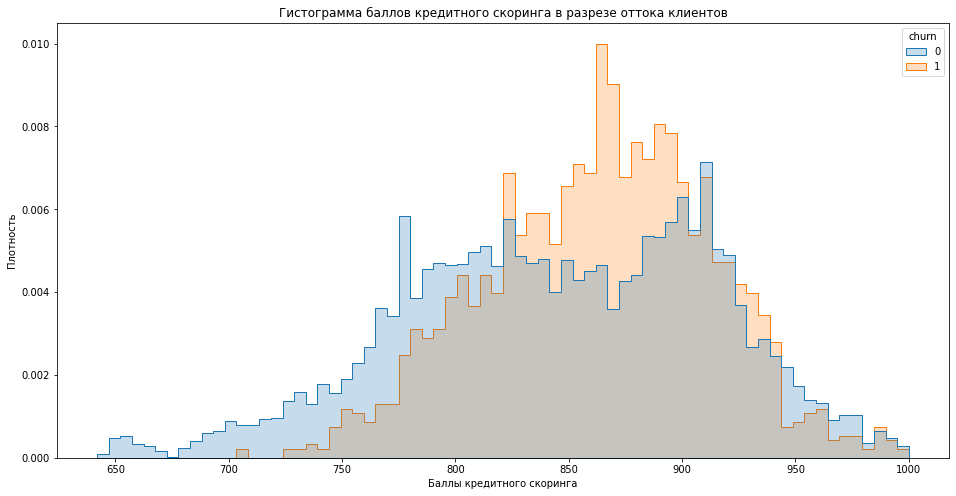

In [28]:
plt.figure(figsize=(16,8))
sns.histplot(data=banks, x='score', hue='churn', element='step', bins=70, stat='density', common_norm=False)
plt.title('Гистограмма баллов кредитного скоринга в разрезе оттока клиентов')
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Плотность')
plt.show()

По гисторамме видим, что отток больше у клиентов с бОльшим кредитным скорингом, максимум находится в диапазоне от 850 до 900

#### Анализ возраста клиентов

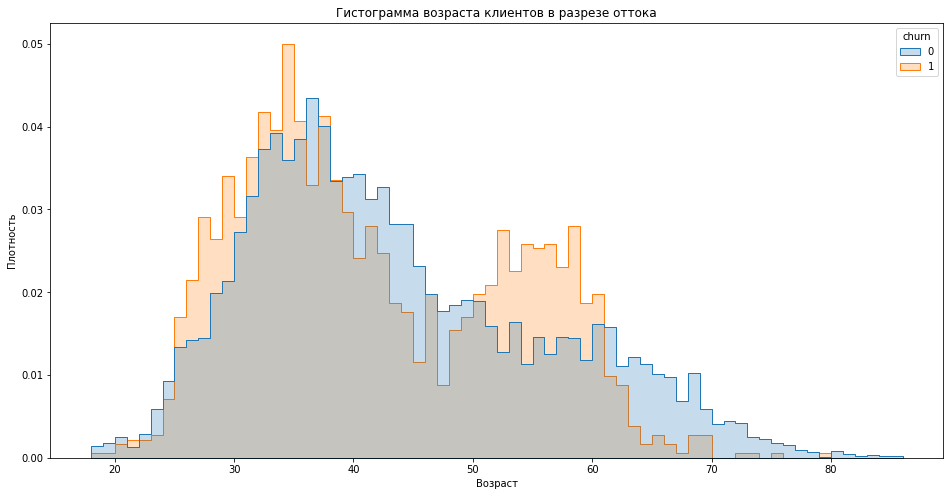

In [29]:
plt.figure(figsize=(16,8))
sns.histplot(data=banks, x='age', hue='churn', element='step', binwidth=1, stat='density', common_norm=False)
plt.title('Гистограмма возраста клиентов в разрезе оттока')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

По гисторамме видим, что отток больше у клиентов в возрасте от 30 до 40, а так же от 50 до 60 лет

#### Анализ баланса

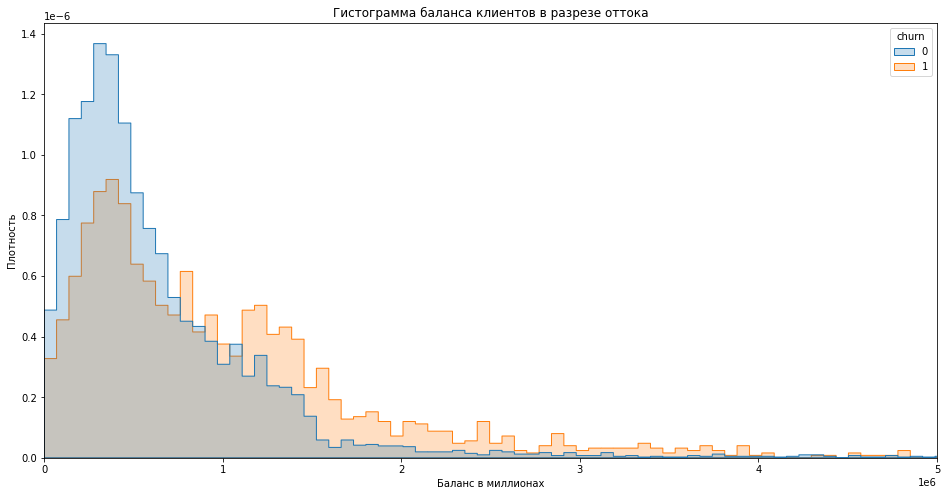

In [30]:
plt.figure(figsize=(16,8))
sns.histplot(data=banks, x='balance', hue='churn', element='step', stat='density', common_norm=False)
plt.title('Гистограмма баланса клиентов в разрезе оттока')
plt.xlabel('Баланс в миллионах')
plt.xlim(0, 5000000)
plt.ylabel('Плотность')
plt.show()

По гисторамме видим, что отток больше у клиентов с балансом до миллиона, точнее в районе 300-500 тысяч, как и в целом по всем клиентам, в том числе и остающимся с банком. Также видим бОльший отток у клиентов с балансом от 1 до 1,5 миллионов

#### Анализ оценочного дохода клиентов

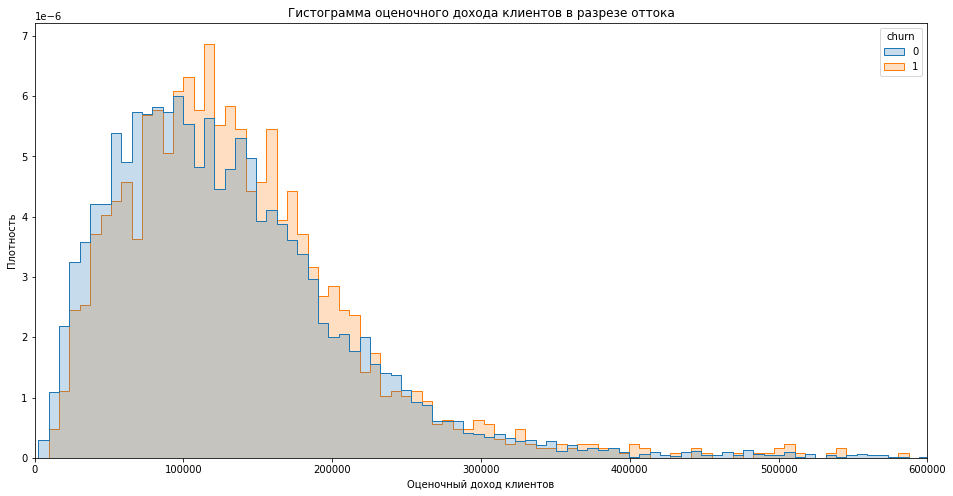

In [31]:
plt.figure(figsize=(16,8))
sns.histplot(data=banks, x='est_salary', hue='churn', element='step', bins=200, stat='density', common_norm=False)
plt.title('Гистограмма оценочного дохода клиентов в разрезе оттока')
plt.xlabel('Оценочный доход клиентов')
plt.xlim(0, 600000)
plt.ylabel('Плотность')
plt.show()

По гисторамме видим, что отток и лояльность клиентов от дохода не зависит и примерно одинаковы по всём диапазоне 

#### Анализ городов проживания

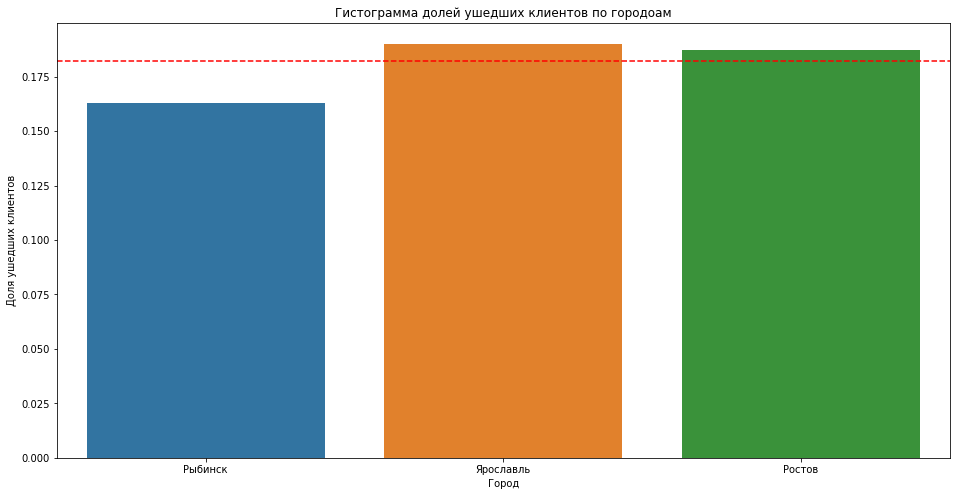

In [32]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='city', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по городоам')
plt.xlabel('Город')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим, что отток клиентов по городам примерно одинаковый, хотя в Рыбинске немного меньше

#### Анализ пола клиентов

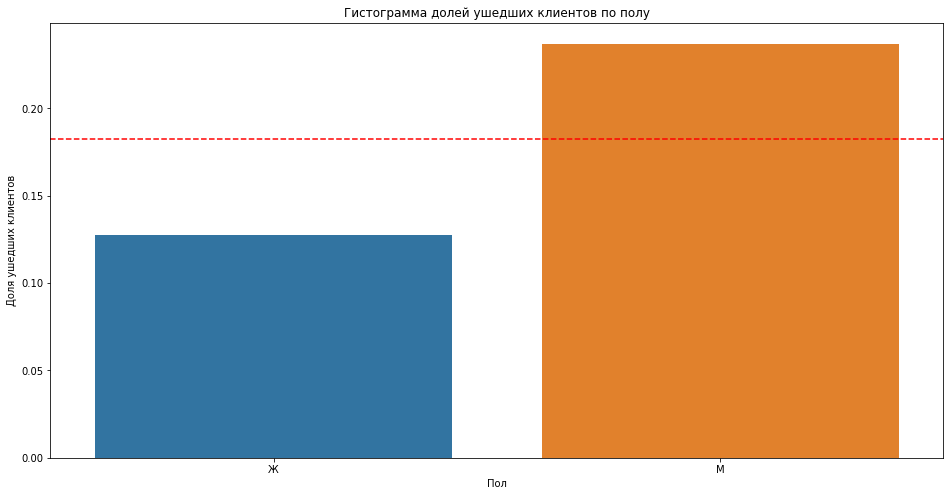

In [33]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='gender', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по полу')
plt.xlabel('Пол')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим, что отток мужчин примерно в два раза выше, чем женщин

#### Анализ количества баллов собственности 

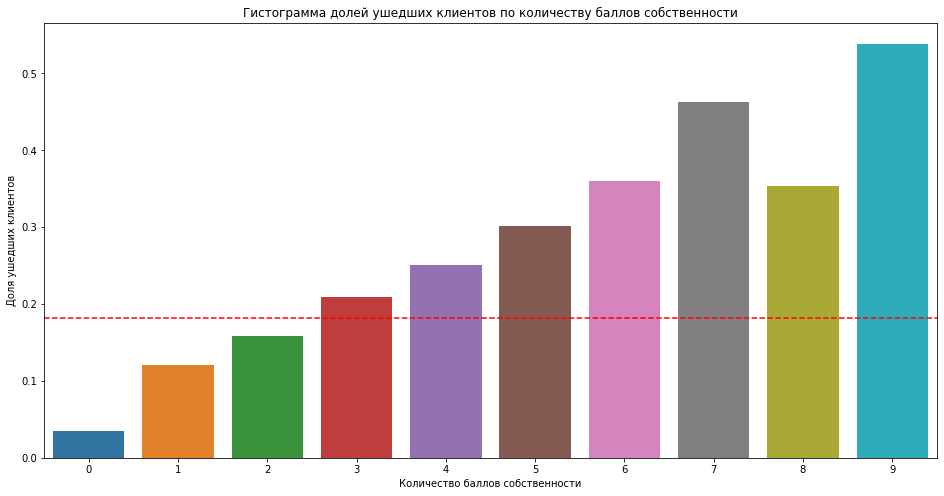

In [34]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='equity', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по количеству баллов собственности')
plt.xlabel('Количество баллов собственности')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим практически прямую зависимость - чем больше у клиентов собственности, тем больше таких клиентов уходит

#### Анализ количества продуктов банка

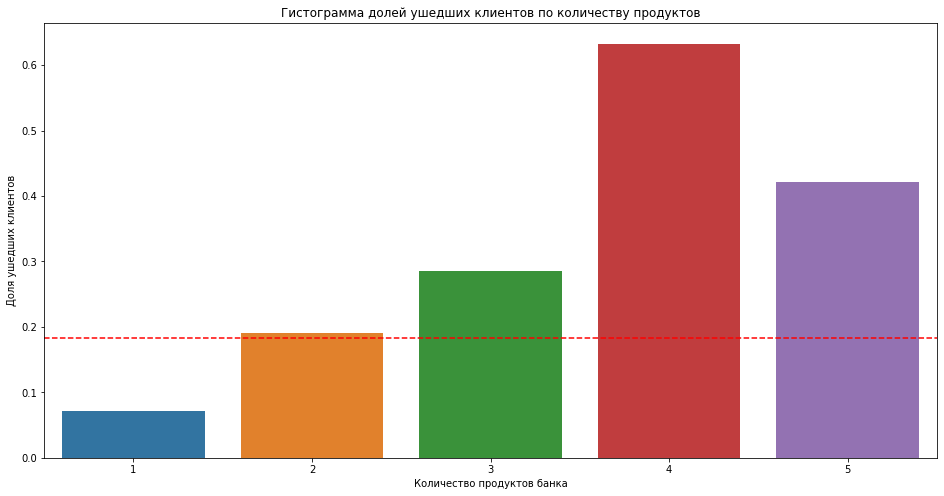

In [35]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='products', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по количеству продуктов')
plt.xlabel('Количество продуктов банка')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим, что больше половины пользователей, имеющих 4 продукта, ушли. По остальным значениям прямая зависимость - чем больше продуктов, тем чаще клиенты уходят

#### Анализ наличия кредитной карты

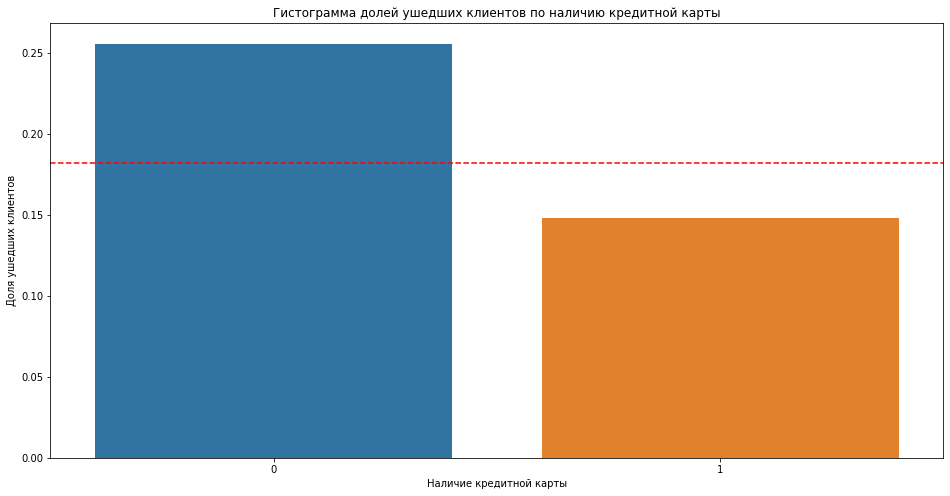

In [36]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='credit_card', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по наличию кредитной карты')
plt.xlabel('Наличие кредитной карты')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим, что примерно на 10% больше ушедших не имели кредитной карты

#### Анализ активности клиентов 

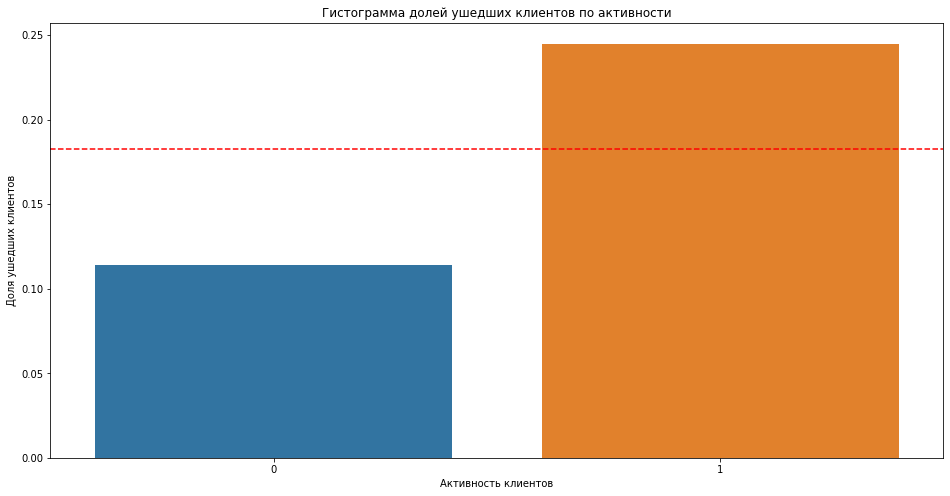

In [37]:
plt.figure(figsize=(16,8))
sns.barplot(data=banks, x='last_activity', y='churn', ci=None)
plt.title('Гистограмма долей ушедших клиентов по активности')
plt.xlabel('Активность клиентов')
plt.axhline(y=banks['churn'].mean(), color='red', linestyle='--')
plt.ylabel('Доля ушедших клиентов')
plt.show()

По гисторамме видим, что совсем уходит гораздо больше тех, кто был активен, что довольно парадоксально, поскольку считаем, что активность учитывается за последний месяц, а отток - за полгода

**Вывод по разделу**  
По построенным гистограммам мы поняли следующее:
- отток больше у клиентов с бОльшим кредитным скорингом, максимум находится в диапазоне от 850 до 900
- отток больше у клиентов в возрасте от 30 до 40, а так же от 50 до 60 лет
- отток больше у клиентов с балансом до миллиона, точнее в районе 300-500 тысяч, как и в целом по всем клиентам, в том числе и остающимся с банком, а также у клиентов с балансом от 1 до 1,5 миллионов
- отток и лояльность клиентов от дохода не зависит и примерно одинаковы по всём диапазоне
- отток клиентов по городам примерно одинаковый, хотя в Рыбинске немного меньше
- отток мужчин примерно в два раза выше, чем женщин
- чем больше у клиентов собственности, тем больше таких клиентов уходит
- больше половины пользователей, имеющих 4 продукта, ушли. По остальным значениям прямая зависимость - чем больше продуктов, тем чаще клиенты уходят
- примерно на 10% больше ушедших не имели кредитной карты

### Корреляционный анализ
  
Построим тепловую карту, показывающую как все количественные параметры коррелируют между собой, исключив сначала столбец user_id из анализа, посколько он может быть не связан со временем заключения договора:

In [38]:
banks_corr=banks
banks_corr.drop('user_id', axis=1, inplace=True)
banks_corr.head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,Ж,М
0,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


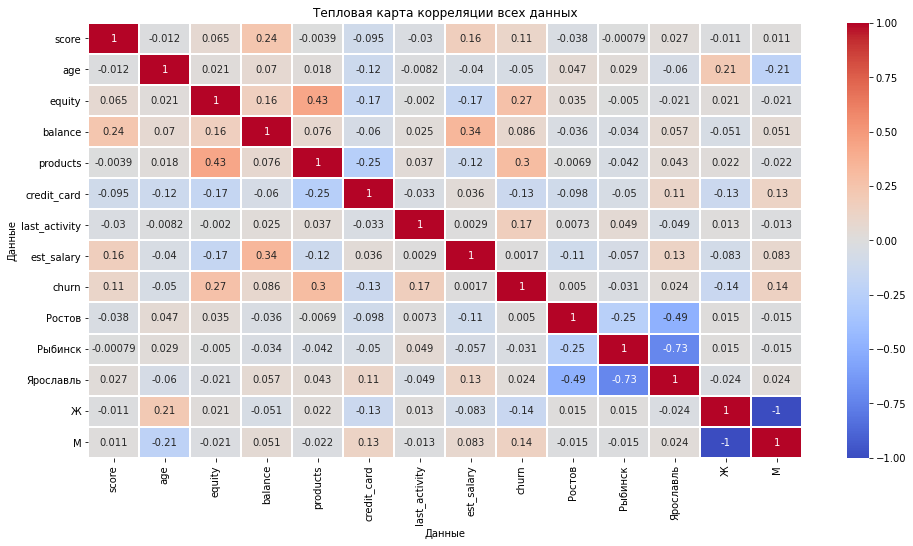

In [39]:
plt.figure(figsize=(16,8))
sns.heatmap(banks_corr.corr(), annot=True, cmap='coolwarm', center=0, linewidths=1)
plt.title('Тепловая карта корреляции всех данных')
plt.xlabel('Данные')
plt.ylabel('Данные')
plt.show()

Проанализируем связи отточности по шкале Чеддока:  
Величина показателя тесноты связи по абсолютной величине - Характеристика связи  
0,1-0,3  - слабая  
0,3-0,5  - умеренная  
0,5-0,7  - заметная  
0,7-0,9  - высокая  
0,9-0,99 - весьма высокая  

По карте видим, что наибольшая связь оттока (сhurn) с количеством продуктов (products) - 0,3; баллам собственности (equity) - 0,27; активностью (last_activity) - 0,17 и баллами кредитного скоринга (score) - 0,11. Так же видим, что мужчины больше коррелируют с оттоков, чем женщины. Хотя по шкале корреляции Чеддока все эти связи слабые.  
  
Касаемо остальных параметров: видим связи умеренной силы (0,3-0,5) между количеством продуктов и баллами собственности (0,43) и между балансом и оценточным доходом (0,34).  
Так же есть связь, правда слабая, между уровнем скоринга и балансом (0,24) и уровнем дохода (0,16), и между наличием кредитной карты и количеством продуктов (-0,25). В целом все эти связи довольно логичные.  
Связи между остальными параметрами (в частности город и пол) либо совсем слабые, либо их нет вообще

## Статистический анализ данных 
Проверка двух статистических гипотез с обоснованием инструмента  
  
Для начала разделим датасет на два по критерию оттёчности клиентов:

In [40]:
churn1=banks.query('churn==1')
churn0=banks.query('churn==0')

### Обоснование выбора теста

Чтобы понять, можно ли применять t-тест, нужно проверить три условия:
- **Генеральные совокупности не зависят друг от друга**  
У нас две независимые выборки, с ушедшимися клиентами и оставшимися
- **Выборочные средние нормально распределены**  
Это условие не должно быть препятствием благодаря ЦПТ. Если размер выборки составляет хотя бы несколько десятков значений, то выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены близко к нормальному вокруг истинного среднего этой совокупности. Это так, даже если сама генеральная совокупность не распределена нормально. 
- **Дисперсии рассматриваемых генеральных совокупностей равны**  
Это коварное условие. С одной стороны, мы никогда точно не знаем, равны ли дисперсии рассматриваемых генеральных совокупностей. С другой — по умолчанию параметр equal_var принимает значение True: дисперсии считаются равными и тест объединяет обе выборки в одну, чтобы эту дисперсию поточнее оценить.  
При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается.  

Посмотрим на размеры выборок:

In [41]:
print('Размер выборки с ушедшими клиентами:', len(churn1))
print('Размер выборки с оставшимимя клиентами:', len(churn0))

Размер выборки с ушедшими клиентами: 1819
Размер выборки с оставшимимя клиентами: 8155


Выборки достаточно большие, значит второе условие тоже выполняется. Дисперсии выборок будем проверять для каждой гипотезы дальше

### Проверка гипотез
#### Проверка гипотезы о различии доходов  
Проверим гипотезу, что доходы ушедших и оставшихся клиентов отличаются, проверив сначала дисперсии:

In [42]:
print('Дисперсия дохода ушедших клиентов',np.var(np.array(churn1['est_salary'])))
print('Дисперсия дохода оставшихся клиентов',np.var(np.array(churn0['est_salary'])))
print()
print('Средний доход ушедших клиентов',np.mean(np.array(churn1['est_salary'])))
print('Средний доход оставшихся клиентов',np.mean(np.array(churn0['est_salary'])))

Дисперсия дохода ушедших клиентов 15104008500.895664
Дисперсия дохода оставшихся клиентов 20356342952.421223

Средний доход ушедших клиентов 148289.70222100057
Средний доход оставшихся клиентов 147674.63788105457


Хоть средний доход по выборкам у нас примерно одинаковый, дисперсии разные. Поскольку и выборки у нас разного размера, укажем параметр equal_var как False, и тест посчитает дисперсии выборок по отдельности.  
  
Сформулируем нулевую и альтернативную гипотезы:
- нулевая гипотеза - доходы ушедших и оставшихся клиентов равны
- альтернативная гипотеза - доходы ушедших и оставшихся клиентов отличаются

In [43]:
alpha=0.05
results1=st.ttest_ind(churn1['est_salary'], churn0['est_salary'], equal_var=False)
print('p-value:', results1.pvalue)
if results1.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.8515799588935961
Не получилось отвергнуть нулевую гипотезу


По результату t-теста можем сделать вывод, что различия в доходах между ушедшими и оставшимися клиентами не имеют статистической значимости

#### Проверка гипотезы о различии возраста  
Проверим гипотезу, что возраст ушедших и оставшихся клиентов отличаются, проверив сначала дисперсии:

In [44]:
print('Дисперсия возраста ушедших клиентов',np.var(np.array(churn1['age'])))
print('Дисперсия возраста оставшихся клиентов',np.var(np.array(churn0['age'])))
print()
print('Средний возраст ушедших клиентов',np.mean(np.array(churn1['age'])))
print('Средний возраст оставшихся клиентов',np.mean(np.array(churn0['age'])))

Дисперсия возраста ушедших клиентов 124.84455601356521
Дисперсия возраста оставшихся клиентов 153.12697193891648

Средний возраст ушедших клиентов 41.450247388675095
Средний возраст оставшихся клиентов 43.02084610668302


Как и в предыдущей гипотезе, хоть средний возраст по выборкам у нас примерно одинаковый, дисперсии разные. И поскольку и выборки у нас разного размера, укажем параметр equal_var как False, и тест посчитает дисперсии выборок по отдельности.  
  
Сформулируем нулевую и альтернативную гипотезы:
- нулевая гипотеза - возраст ушедших и оставшихся клиентов равен
- альтернативная гипотеза - возраст ушедших и оставшихся клиентов отличается

In [45]:
# alpha=0.05 (задали в предыдущем тесте)
results2=st.ttest_ind(churn1['age'], churn0['age'], equal_var=False)
print('p-value:', results2.pvalue)
if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.1721656853879547e-07
Отвергаем нулевую гипотезу


По результату t-теста можем сделать вывод, что различия в возрасте между ушедшими и оставшимися клиентами имеют статистическую значимость  
  
А по гистограмме возраста в разрезе оттока клиентов (из пункта 3.1.2) помним, что среди отточных у нас есть клиенты в возрасте 30-40 лет, как и среди оставшихся, но также есть много ушедших клиентов в возрасте 50-60 лет  

**Вывод разделу**  
Предварительно приведя обоснование использование t-теста, мы проверили две гипотезы: первая гипотеза о различии доходов была отвергнута, то есть считаем, что доходы равны, а вторая - о различии в возрасте - подтвердилась, то есть возраст в выборках по отточности отличается 

## Подведение промежуточных итогов 
**Выводы по результатам EDA, корреляционного анализа и гипотез, выделение признаков, влияющих на отток**  
  
На этом этапе мы выберем признаки, которые лягут в основу нашей сегментации.  
Не будем выделять много сегментирующих признаков, чтобы сегменты не получились слишком узкими - так мы не сможем охватить много клиентов в пределах сегмента, и это повышает риск того, что мероприятие по удержанию клиентов не окажется эффективным. С другой стороны, слишком широкие сегменты в погоней за высоким уровнем оттока тоже не стоит делать - к таким сегментам сложно подобрать рекомендации, и мы рискуем не удержать никого.  

**----------------------------------------------------------------------------------------------------------------------------------------**

В качестве **первого признака возьмём пол** - отток мужчин примерно в два раза выше, чем женщин  
  
За **второй признак возьмём возраст**:  
по проверке гипотезы - возраст отличается  
по ИДА - отток больше у клиентов в возрасте от 30 до 40, а так же от 50 до 60 лет, второй интервал нам более интересен, как как в первого показатели лояльности клиентов схожи с отточностью  
  
Также существенно больше клиентов ушли **со следующими признаками** (в разные сегменты будем брать по одному из этих признаков, чтобы в итоге подобрать большие сегменты с оттоком выше среднего):
- это жители Ярославля и Ростова
- клиенты с 4 продуктами в банке
- у клиентов было много собственности - 9 баллов
- кредитный скоринг 850-900
- у клиентов не было кредитной карты


## Сегментация

Подберём такие сегменты, в которых будет от 500 клиентов и отток больше, чем средний уровень оттока по банку - 18%.   
Сегментацию мы будем проводить по результатам работы в прошлых блоках, то есть по выделенным признакам и их интервалам, включающим наибольший процент оттока клиентов

### 1ый сегмент
Мужчины в возрасте 50-60 лет из Ярославля

In [46]:
segment1=banks.query('М==1 and age>=50 and age<=60 and Ярославль==1')
print('Количество клиентов в сегменте', len(segment1))

Количество клиентов в сегменте 432


Немного расширим возраст до 49-62 лет

In [47]:
segment1=banks.query('М==1 and age>=49 and age<=62 and Ярославль==1')
print('Количество клиентов в сегменте', len(segment1))

Количество клиентов в сегменте 529


Посчитаем число и долю отточных клиентов в этом сегменте:

In [48]:
segment1_churn=banks.query('churn==1 and М==1 and age>=50 and age<=60 and Ярославль==1')
print('Количество ушедших клиентов', len(segment1_churn))
print('Доля ушедших клиентов', len(segment1_churn)/len(segment1))

Количество ушедших клиентов 144
Доля ушедших клиентов 0.2722117202268431


### 2ой сегмент
Женщины в возрасте 30-40 лет

In [49]:
segment2=banks.query('Ж==1 and age>=30 and age<=40')
print('Количество клиентов в сегменте', len(segment2))

Количество клиентов в сегменте 1758


Посчитаем число и долю отточных клиентов в этом сегменте:

In [50]:
segment2_churn=banks.query('churn==1 and Ж==1 and age>=30 and age<=40')
print('Количество ушедших клиентов', len(segment2_churn))
print('Доля ушедших клиентов', len(segment2_churn)/len(segment2))

Количество ушедших клиентов 239
Доля ушедших клиентов 0.13594994311717862


В таком сегменте отточность получилась ниже средней

### 3ий сегмент
Женщины c кредитным скорингом 850-900 и 4 банковскими продуктами

In [51]:
segment3=banks.query('Ж==1 and score>=850 and score<=900 and products==4')
print('Количество клиентов в сегменте', len(segment3))

Количество клиентов в сегменте 86


В таком сегменте получилось мало клиентов

### 4ый сегмент
Клиенты с 4 банковскими продуктами и 9 баллами собственности

In [52]:
segment4=banks.query('products==4 and equity==9')
print('Количество клиентов в сегменте', len(segment4))

Количество клиентов в сегменте 2


В таком сегменте получилось очень мало клиентов

### 5ый сегмент
Мужчины c кредитным скорингом 850-900

In [53]:
segment5=banks.query('М==1 and score>=850 and score<=900')
print('Количество клиентов в сегменте', len(segment5))

Количество клиентов в сегменте 1335


Посчитаем число и долю отточных клиентов в этом сегменте:

In [54]:
segment5_churn=banks.query('churn==1 and М==1 and score>=850 and score<=900')
print('Количество ушедших клиентов', len(segment5_churn))
print('Доля ушедших клиентов', len(segment5_churn)/len(segment5))

Количество ушедших клиентов 435
Доля ушедших клиентов 0.3258426966292135


### 6ой сегмент
Клиенты в возрасте 30-40 лет без кредитной карты

In [55]:
segment6=banks.query('age>=30 and age<=40 and credit_card==0')
print('Количество клиентов в сегменте', len(segment6))

Количество клиентов в сегменте 1108


Посчитаем число и долю отточных клиентов в этом сегменте:

In [56]:
segment6_churn=banks.query('churn==1 and age>=30 and age<=40 and credit_card==0')
print('Количество ушедших клиентов', len(segment6_churn))
print('Доля ушедших клиентов', len(segment6_churn)/len(segment6))

Количество ушедших клиентов 311
Доля ушедших клиентов 0.2806859205776173


### 7ой сегмент
Мужчины в возрасте 49-62 лет без кредитной карты

In [57]:
segment7=banks.query('М==1 and age>=49 and age<=62 and credit_card==0')
print('Количество клиентов в сегменте', len(segment7))

Количество клиентов в сегменте 336


В таком сегменте получилось недостаточно клиентов

## Приоритизация сегментов

Поскольку наш отдел маркетинга включает только двух работников, у них нет автоматизированных систем, поэтому все мероприятия, рассылки и агитации будут выполнены ручным трудом. Поэтому важно приоритизировать сегменты, чтобы маркетинг знал, на что обратить внимание в первую очередь в случае, если ресурсов маркетинга не хватит на охват всех выделенных сегментов.  
  
Приоритизируем гипотезы по мере убывания количества отточных клиентов, чтобы в первую очередь охватить сегменты с наибольшим их количеством:  
  
1. Мужчины c кредитным скорингом 850-900 - 1335 человек - 33% отток
2. Клиенты в возрасте 30-40 лет без кредитной карты - 1108 человек - 28% отток
3. Мужчины в возрасте 49-62 лет из Ярославля - 529 человек - 27% отток

## Формирование таргетированных рекомендаций
Сформируем для отдела маркетинга рекомендации по работе с выделенными сегментами отточных клиентов  
  
1ый сегмент: Мужчины c кредитным скорингом 850-900 - 33% оттока  
- предложить выгодные условия по любому кредиту (например ипотеке или автокредиту)
- не зарплатным клиентам предложить перевести зарплату в банк с последующими специальными условиями как для зарплатных клиентов
- пенсионерам предложить перевести пенсию в банк на выгодных условиях
- чаще предлагать категории кэшбэка, покупки в которых совершает клиент, а также например в категориях активного отдыха, спорта или детских товаров
  
2ой сегмент: Клиенты в возрасте 30-40 лет без кредитной карты - 28% оттока  
- предложить кредитную карту на льготных и выгодных условиях
- не зарплатным клиентам предложить перевести зарплату в банк с последующими специальными условиями как для зарплатных клиентов
- чаще предлагать категории кэшбэка, покупки в которых совершает клиент, а также например в категориях активного отдыха, спорта или детских товаров, женщинам - на косметику или одежду 
- предложить выгодные условия по ипотеке или автокредиту

3ий сегмент: Мужчины в возрасте 49-62 лет из Ярославля - 27% оттока  
- не зарплатным клиентам предложить перевести зарплату в банк с последующими специальными условиями как для зарплатных клиентов
- пенсионерам предложить перевести пенсию в банк на выгодных условиях
- чаще предлагать категории кэшбэка, покупки в которых совершает клиент, а также например в категориях товаров для охоты, рыбалки или строительства
- провести проверку по качеству обслуживания как в отделениях, так и онлайн клиентов в Ярославле
  
И из общих рекомендаций:  
- ненавязчиво информировать клиентов о новых продуктах
- сегментам отточных клиентов предлагать повышенные ставки по вкладам

# Выводы по проекту

В проекте был проанализирован датасет с данными клиентов "Метанпромбанка» в Ярославле, Ростове и Рыбинске в разрезе их отточности из банка.  
  
Сначала мы подготовили данные: переименовали столбцы, обработали пропуски и дубликаты, закодировали переменные городов и пола, и проверили корректность данных.  
  
Затем провели исследовательский анализ: посмотрели распределение всех признаков, как количественных, так и категориальных, в разрере оттока клиентов, провели корреляционный анализ, на основании чего выявили зависимость оттока клиентов от таких параметров, как кредитный скоринг, возраст, баланс, пол, количество собственности, количество продуктов и наличие кредитной карты.  
  
Провели статистический анализ, проверив две гипотезы, предварительно приведя обоснование использование t-теста: первая гипотеза о различии доходов была отвергнута, то есть считаем, что доходы равны, а вторая - о различии в возрасте - подтвердилась, то есть возраст в выборках по отточности отличается.  
  
Подвели промежуточные итоги, отобрав признаки для сегментации отточных пользователей, по которым потом собственно и сформировали сегменты, из которых в свою очередь отобрали и приоритизировали сегменты с более 500 клиентами и отточностью больше средней по банку.  
  
В итоге отобрав три сегмента, дали рекомендации отделу маркетинга по работе с выявленными сегментами отточных клиентов.

# Презентация  

Ссылка:  